所有库导入成功！
PyTorch版本: 2.7.1+cu118
CUDA是否可用: True
探索HDF5文件结构...
文件中的数据集:
  - ans: shape=(15000,), dtype=uint8
  - dec: shape=(15000,), dtype=float64
  - images: shape=(15000, 256, 256, 3), dtype=uint8
  - pxscale: shape=(15000,), dtype=float64
  - ra: shape=(15000,), dtype=float64
  - redshift: shape=(15000,), dtype=float64
数据加载成功！

数据基本信息:
图像数据形状: (15000, 256, 256, 3)
标签数据形状: (15000,)
赤经(ra)形状: (15000,), 范围: [0.007, 359.951]
赤纬(dec)形状: (15000,), 范围: [-19.054, 69.767]
红移(redshift)形状: (15000,)
像素比例(pxscale)形状: (15000,), 范围: [0.262, 0.524]

分类标签唯一值: [0 1 2 3 4 5 6 7 8 9]
类别数量: 10

生成数据可视化...


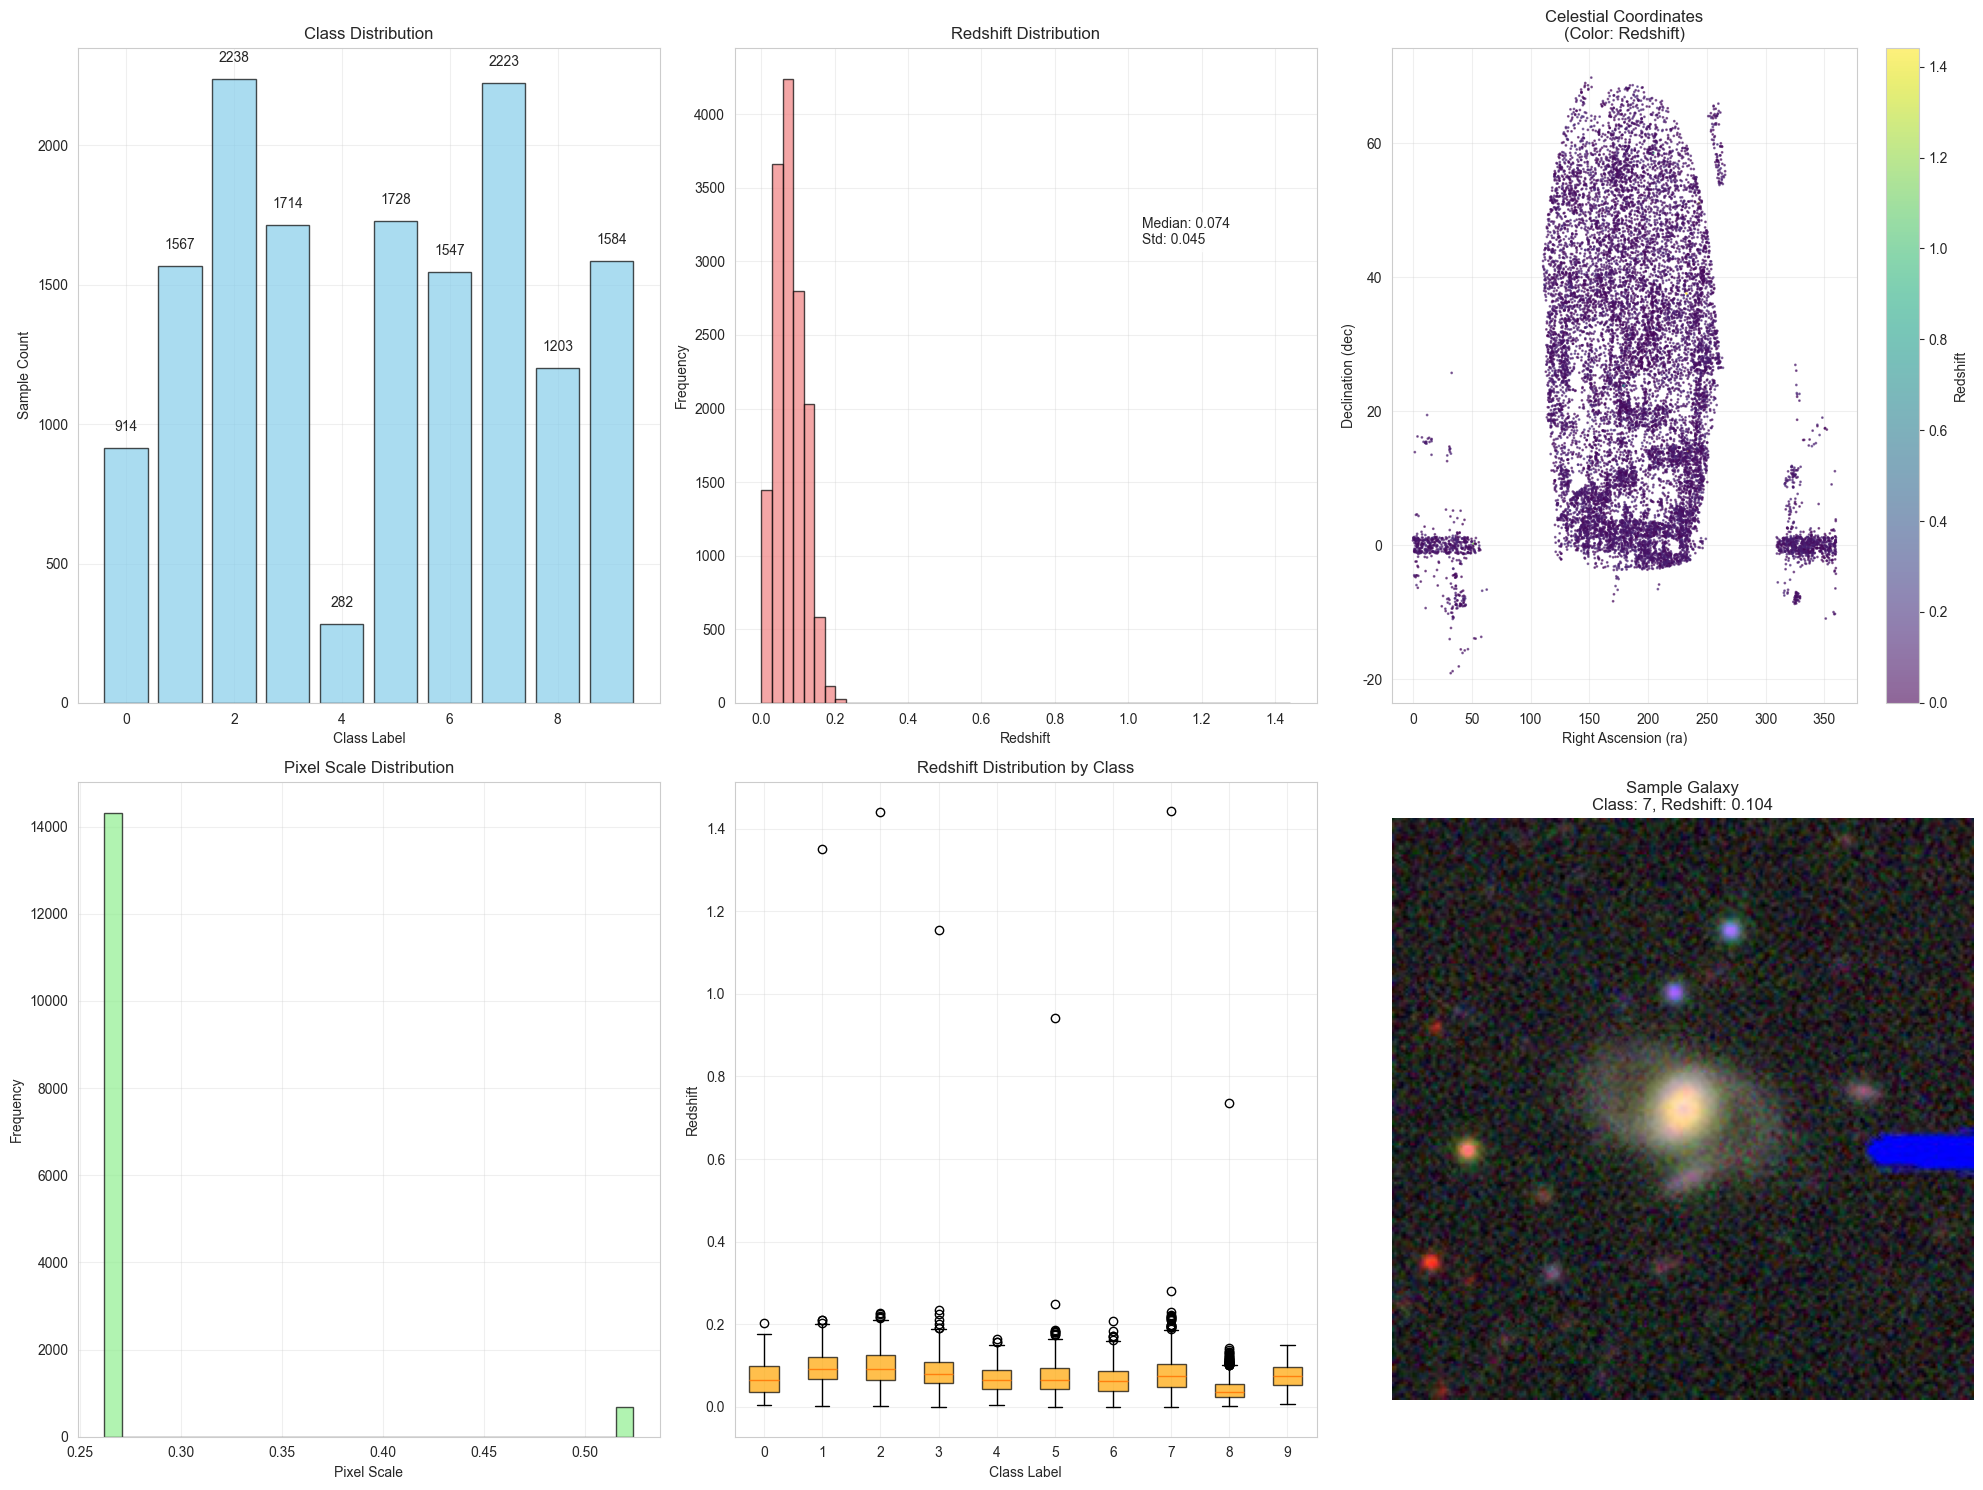


数据质量检查:
图像数据中NaN值数量: 0
标签中NaN值数量: 0
红移中NaN值数量: 84

图像数值范围: [0.000, 255.000]
图像数据类型: uint8

数据摘要:
num_samples: 15000
num_samples_with_redshift: 14916
num_samples_with_nan_redshift: 84
image_shape: (256, 256, 3)
num_classes: 10
redshift_range: [np.float64(-0.0001244358), np.float64(1.441647)]
redshift_median: 0.07363950999999999
redshift_std: 0.04458165338378748
class_distribution: {np.uint8(0): np.int64(914), np.uint8(1): np.int64(1567), np.uint8(2): np.int64(2238), np.uint8(3): np.int64(1714), np.uint8(4): np.int64(282), np.uint8(5): np.int64(1728), np.uint8(6): np.int64(1547), np.uint8(7): np.int64(2223), np.uint8(8): np.int64(1203), np.uint8(9): np.int64(1584)}

第一阶段完成！数据探索完毕。


In [2]:
# 第一阶段：环境准备与数据探索 

# 1. 导入必要的库
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 设置图形样式
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

print("所有库导入成功！")
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA是否可用: {torch.cuda.is_available()}")

# 2. 加载并探索HDF5文件结构
def explore_hdf5_structure(file_path):
    """探索HDF5文件的结构"""
    print("=" * 50)
    print("探索HDF5文件结构...")
    
    with h5py.File(file_path, 'r') as f:
        print("文件中的数据集:")
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"  - {name}: shape={obj.shape}, dtype={obj.dtype}")
        
        f.visititems(print_structure)
        
        # 读取所有数据
        images = f['images'][:]
        labels = f['ans'][:]
        ra = f['ra'][:]
        dec = f['dec'][:]
        redshift = f['redshift'][:]
        pxscale = f['pxscale'][:]
    
    return images, labels, ra, dec, redshift, pxscale

# 使用您的文件路径
file_path = r"F:\Desktop\2517星系特征提取\train.hdf5"

try:
    images, labels, ra, dec, redshift, pxscale = explore_hdf5_structure(file_path)
    print("数据加载成功！")
except Exception as e:
    print(f"数据加载失败: {e}")
    import traceback
    traceback.print_exc()

# 3. 数据基本信息统计
print("\n" + "=" * 50)
print("数据基本信息:")
print(f"图像数据形状: {images.shape}")
print(f"标签数据形状: {labels.shape}")
print(f"赤经(ra)形状: {ra.shape}, 范围: [{ra.min():.3f}, {ra.max():.3f}]")
print(f"赤纬(dec)形状: {dec.shape}, 范围: [{dec.min():.3f}, {dec.max():.3f}]")
print(f"红移(redshift)形状: {redshift.shape}")
print(f"像素比例(pxscale)形状: {pxscale.shape}, 范围: [{pxscale.min():.3f}, {pxscale.max():.3f}]")

# 检查唯一值
unique_labels = np.unique(labels)
print(f"\n分类标签唯一值: {unique_labels}")
print(f"类别数量: {len(unique_labels)}")

# 4. 数据可视化
def create_visualizations(images, labels, ra, dec, redshift, pxscale):
    """创建综合数据可视化"""
    
    # 创建子图布局
    fig = plt.figure(figsize=(20, 15))
    
    # 4.1 分类标签分布
    plt.subplot(2, 3, 1)
    label_counts = pd.Series(labels).value_counts().sort_index()
    bars = plt.bar(label_counts.index, label_counts.values, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Class Label')
    plt.ylabel('Sample Count')
    plt.title('Class Distribution')
    plt.grid(True, alpha=0.3)
    
    # 在柱子上添加数量标注
    for bar, count in zip(bars, label_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                f'{count}', ha='center', va='bottom', fontsize=10)
    
    # 4.2 红移分布（处理NaN值）
    plt.subplot(2, 3, 2)
    redshift_clean = redshift[~np.isnan(redshift)]
    plt.hist(redshift_clean, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
    plt.xlabel('Redshift')
    plt.ylabel('Frequency')
    plt.title('Redshift Distribution')
    plt.grid(True, alpha=0.3)
    
    # 添加统计信息
    redshift_stats = f"Median: {np.median(redshift_clean):.3f}\nStd: {np.std(redshift_clean):.3f}"
    plt.text(0.7, 0.7, redshift_stats, transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
             fontsize=10)
    
    # 4.3 天体坐标分布
    plt.subplot(2, 3, 3)
    valid_mask = ~np.isnan(redshift)
    scatter = plt.scatter(ra[valid_mask], dec[valid_mask], c=redshift[valid_mask], 
                         cmap='viridis', alpha=0.6, s=1)
    plt.colorbar(scatter, label='Redshift')
    plt.xlabel('Right Ascension (ra)')
    plt.ylabel('Declination (dec)')
    plt.title('Celestial Coordinates\n(Color: Redshift)')
    plt.grid(True, alpha=0.3)
    
    # 4.4 像素比例分布
    plt.subplot(2, 3, 4)
    plt.hist(pxscale, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.xlabel('Pixel Scale')
    plt.ylabel('Frequency')
    plt.title('Pixel Scale Distribution')
    plt.grid(True, alpha=0.3)
    
    # 4.5 各类别红移统计
    plt.subplot(2, 3, 5)
    label_redshift_data = []
    valid_labels = []
    
    for label in unique_labels:
        mask = (labels == label) & (~np.isnan(redshift))
        if np.sum(mask) > 0:
            label_redshift_data.append(redshift[mask])
            valid_labels.append(label)
    
    if label_redshift_data:
        boxplot = plt.boxplot(label_redshift_data, labels=valid_labels, patch_artist=True)
        for patch in boxplot['boxes']:
            patch.set_facecolor('orange')
            patch.set_alpha(0.7)
        
        plt.xlabel('Class Label')
        plt.ylabel('Redshift')
        plt.title('Redshift Distribution by Class')
        plt.grid(True, alpha=0.3)
    
    # 4.6 示例图像展示
    plt.subplot(2, 3, 6)
    valid_indices = np.where(~np.isnan(redshift))[0]
    if len(valid_indices) > 0:
        random_idx = np.random.choice(valid_indices)
        sample_image = images[random_idx]
        sample_image_normalized = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())
        
        plt.imshow(sample_image_normalized)
        plt.title(f'Sample Galaxy\nClass: {labels[random_idx]}, Redshift: {redshift[random_idx]:.3f}')
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, 'No valid samples with redshift data', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 执行可视化
print("\n生成数据可视化...")
fig = create_visualizations(images, labels, ra, dec, redshift, pxscale)

# 5. 数据质量检查
print("\n" + "=" * 50)
print("数据质量检查:")

# 检查缺失值
print(f"图像数据中NaN值数量: {np.isnan(images).sum()}")
print(f"标签中NaN值数量: {np.isnan(labels).sum()}")
print(f"红移中NaN值数量: {np.isnan(redshift).sum()}")

# 检查图像数值范围
print(f"\n图像数值范围: [{images.min():.3f}, {images.max():.3f}]")
print(f"图像数据类型: {images.dtype}")

# 6. 保存处理后的基本信息
redshift_clean = redshift[~np.isnan(redshift)]
valid_indices = ~np.isnan(redshift)

data_info = {
    'num_samples': len(images),
    'num_samples_with_redshift': np.sum(valid_indices),
    'num_samples_with_nan_redshift': np.sum(np.isnan(redshift)),
    'image_shape': images.shape[1:],
    'num_classes': len(unique_labels),
    'redshift_range': [redshift_clean.min(), redshift_clean.max()],
    'redshift_median': np.median(redshift_clean),
    'redshift_std': np.std(redshift_clean),
    'class_distribution': dict(zip(unique_labels, np.bincount(labels)))
}

print("\n" + "=" * 50)
print("数据摘要:")
for key, value in data_info.items():
    print(f"{key}: {value}")

print("\n第一阶段完成！数据探索完毕。")

In [3]:
# 第二阶段：数据预处理与PyTorch Dataset构建 

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

print("开始第二阶段：数据预处理与Dataset构建...")

# 1. 数据清洗和质量分析
print("\n1. 数据清洗和质量分析...")

# 找到红移为NaN的索引
nan_redshift_indices = np.where(np.isnan(redshift))[0]
print(f"发现 {len(nan_redshift_indices)} 个红移为NaN的样本")

# 创建有效数据的掩码
valid_mask = ~np.isnan(redshift)
print(f"有效数据样本数量: {np.sum(valid_mask)}")

# 只保留有效数据
images_clean = images[valid_mask]
labels_clean = labels[valid_mask]
ra_clean = ra[valid_mask]
dec_clean = dec[valid_mask]
redshift_clean = redshift[valid_mask]
pxscale_clean = pxscale[valid_mask]

# 修复负红移值
redshift_fixed = redshift_clean.copy()
negative_mask = redshift_fixed < 0
redshift_fixed[negative_mask] = 0.0
print(f"修复负红移值: {np.sum(negative_mask)} 个样本")

print(f"清洗后数据形状:")
print(f"  images: {images_clean.shape}")
print(f"  labels: {labels_clean.shape}")
print(f"  redshift: {redshift_fixed.shape}")

# 2. 数据集划分
print("\n2. 数据集划分...")

# 划分训练集和临时集
train_indices, temp_indices = train_test_split(
    range(len(images_clean)), 
    test_size=0.3, 
    random_state=42,
    stratify=labels_clean
)

# 划分验证集和测试集
val_indices, test_indices = train_test_split(
    temp_indices, 
    test_size=0.5, 
    random_state=42,
    stratify=labels_clean[temp_indices]
)

print(f"训练集大小: {len(train_indices)}")
print(f"验证集大小: {len(val_indices)}")
print(f"测试集大小: {len(test_indices)}")

# 3. 定义数据预处理
print("\n3. 定义数据预处理和增强...")

# ImageNet的均值和标准差
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# 训练集的数据增强
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# 验证集和测试集的预处理
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("数据预处理管道定义完成!")

# 4. 创建自定义Dataset类
class GalaxyDataset(Dataset):
    def __init__(self, images, labels, redshift, ra, dec, transform=None, task_type='both'):
        """
        星系数据集类
        """
        self.images = images
        self.labels = labels
        self.redshift = redshift
        self.ra = ra
        self.dec = dec
        self.transform = transform
        self.task_type = task_type
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        redshift_val = self.redshift[idx]
        
        if self.transform:
            image = self.transform(image)
        
        if self.task_type == 'classification':
            return image, label
        elif self.task_type == 'regression':
            return image, redshift_val
        else:  # 'both' - 多任务学习
            return image, label, redshift_val

# 5. 创建数据集实例
print("\n4. 创建数据集实例...")

# 创建训练集、验证集、测试集
train_dataset = GalaxyDataset(
    images=images_clean[train_indices],
    labels=labels_clean[train_indices],
    redshift=redshift_fixed[train_indices],
    ra=ra_clean[train_indices],
    dec=dec_clean[train_indices],
    transform=train_transform,
    task_type='both'
)

val_dataset = GalaxyDataset(
    images=images_clean[val_indices],
    labels=labels_clean[val_indices],
    redshift=redshift_fixed[val_indices],
    ra=ra_clean[val_indices],
    dec=dec_clean[val_indices],
    transform=val_transform,
    task_type='both'
)

test_dataset = GalaxyDataset(
    images=images_clean[test_indices],
    labels=labels_clean[test_indices],
    redshift=redshift_fixed[test_indices],
    ra=ra_clean[test_indices],
    dec=dec_clean[test_indices],
    transform=val_transform,
    task_type='both'
)

print(f"训练集: {len(train_dataset)} 个样本")
print(f"验证集: {len(val_dataset)} 个样本")
print(f"测试集: {len(test_dataset)} 个样本")

# 6. 创建DataLoader
print("\n5. 创建DataLoader...")

# 根据类别不平衡设置样本权重
def calculate_class_weights(labels):
    class_counts = Counter(labels)
    total_samples = len(labels)
    num_classes = len(class_counts)
    
    weights = [total_samples / (num_classes * count) for count in class_counts.values()]
    weights = torch.tensor(weights, dtype=torch.float32)
    weights = weights / weights.sum()
    
    return weights

class_weights = calculate_class_weights(labels_clean[train_indices])
print(f"类别权重: {class_weights}")

# 创建数据加载器
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"DataLoader创建完成!")
print(f"批次大小: {batch_size}")
print(f"训练集批次数量: {len(train_loader)}")
print(f"验证集批次数量: {len(val_loader)}")
print(f"测试集批次数量: {len(test_loader)}")

# 7. 测试数据加载器
print("\n6. 测试数据加载器...")

sample_idx = 0
sample_image, sample_label, sample_redshift = train_dataset[sample_idx]
print(f"单个样本测试:")
print(f"  图像形状: {sample_image.shape}")
print(f"  标签: {sample_label}")
print(f"  红移: {sample_redshift:.4f}")

# 测试数据加载器
try:
    for batch_idx, (images_batch, labels_batch, redshift_batch) in enumerate(train_loader):
        print(f"\n批次 {batch_idx + 1}测试成功:")
        print(f"  图像形状: {images_batch.shape}")
        print(f"  标签形状: {labels_batch.shape}")
        print(f"  红移形状: {redshift_batch.shape}")
        break
except Exception as e:
    print(f"数据加载器测试失败: {e}")

# 8. 保存数据集信息
print("\n7. 保存数据集信息...")

dataset_info = {
    'num_classes': 10,
    'class_names': [f'Class_{i}' for i in range(10)],
    'class_weights': class_weights.numpy(),
    'redshift_stats': {
        'mean': float(np.mean(redshift_fixed)),
        'std': float(np.std(redshift_fixed)),
        'min': float(np.min(redshift_fixed)),
        'max': float(np.max(redshift_fixed)),
        'median': float(np.median(redshift_fixed))
    },
    'dataset_sizes': {
        'train': len(train_dataset),
        'val': len(val_dataset),
        'test': len(test_dataset)
    },
    'input_shape': (3, 256, 256)
}

print("数据集信息:")
for key, value in dataset_info.items():
    if key != 'class_weights':
        print(f"  {key}: {value}")

print("\n第二阶段完成！数据预处理和Dataset构建完毕。")

开始第二阶段：数据预处理与Dataset构建...

1. 数据清洗和质量分析...
发现 84 个红移为NaN的样本
有效数据样本数量: 14916
修复负红移值: 1 个样本
清洗后数据形状:
  images: (14916, 256, 256, 3)
  labels: (14916,)
  redshift: (14916,)

2. 数据集划分...
训练集大小: 10441
验证集大小: 2237
测试集大小: 2238

3. 定义数据预处理和增强...
数据预处理管道定义完成!

4. 创建数据集实例...
训练集: 10441 个样本
验证集: 2237 个样本
测试集: 2238 个样本

5. 创建DataLoader...
类别权重: tensor([0.0676, 0.0472, 0.0616, 0.0892, 0.0477, 0.0683, 0.1163, 0.0612, 0.0667,
        0.3742])
DataLoader创建完成!
批次大小: 32
训练集批次数量: 327
验证集批次数量: 70
测试集批次数量: 70

6. 测试数据加载器...
单个样本测试:
  图像形状: torch.Size([3, 256, 256])
  标签: 1
  红移: 0.0983

批次 1测试成功:
  图像形状: torch.Size([32, 3, 256, 256])
  标签形状: torch.Size([32])
  红移形状: torch.Size([32])

7. 保存数据集信息...
数据集信息:
  num_classes: 10
  class_names: ['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']
  redshift_stats: {'mean': 0.07766050262081027, 'std': 0.04458163883975486, 'min': 0.0, 'max': 1.441647, 'median': 0.07363950999999999}
  dataset_sizes: {'train': 

In [17]:
# 第三阶段：模型训练与验证 

import time
import os
from tqdm import tqdm

print("开始第三阶段：模型训练与验证...")

# 1. 数据最终处理 - 使用第二阶段的数据
print("\n1. 数据最终处理...")

# 直接使用第二阶段清洗过的数据
redshift_clean = redshift_fixed

# 计算统计量并识别异常值（使用IQR方法）
Q1 = np.percentile(redshift_clean, 25)  # 第一四分位数
Q3 = np.percentile(redshift_clean, 75)  # 第三四分位数
IQR = Q3 - Q1  # 四分位距
lower_bound = max(0, Q1 - 1.5 * IQR)  # 下界，确保不小于0
upper_bound = Q3 + 3 * IQR  # 上界，使用3倍IQR以保留更多数据

print(f"红移统计:")
print(f"  中位数: {np.median(redshift_clean):.4f}")
print(f"  Q1: {Q1:.4f}, Q3: {Q3:.4f}, IQR: {IQR:.4f}")
print(f"  异常值边界: [{lower_bound:.4f}, {upper_bound:.4f}]")

# 找到异常值
outlier_mask = (redshift_clean > upper_bound) | (redshift_clean < lower_bound)
print(f"发现的异常值数量: {np.sum(outlier_mask)}")

# 创建有效样本的索引
valid_indices = np.where(~outlier_mask)[0]  # 非异常值的索引
print(f"最终有效样本数量: {len(valid_indices)}")

# 使用有效数据
images_final = images_clean[valid_indices]
labels_final = labels_clean[valid_indices]
redshift_final = redshift_clean[valid_indices]

# 重新计算统计量并进行标准化
redshift_mean_final = np.mean(redshift_final)
redshift_std_final = np.std(redshift_final)
redshift_final_scaled = (redshift_final - redshift_mean_final) / redshift_std_final  # Z-score标准化

print(f"\n最终红移统计:")
print(f"  原始范围: [{redshift_final.min():.6f}, {redshift_final.max():.6f}]")
print(f"  标准化后范围: [{redshift_final_scaled.min():.3f}, {redshift_final_scaled.max():.3f}]")

# 2. 重新划分数据集
print("\n2. 重新划分数据集...")

# 划分训练集和临时集（测试集+验证集）
train_indices_final, temp_indices_final = train_test_split(
    range(len(images_final)), 
    test_size=0.3,  # 30%作为测试验证集
    random_state=42,  # 固定随机种子保证可重复性
    stratify=labels_final  # 分层抽样保持类别分布
)

# 从临时集中划分验证集和测试集
val_indices_final, test_indices_final = train_test_split(
    temp_indices_final, 
    test_size=0.5,  # 各占临时集的一半
    random_state=42,
    stratify=labels_final[temp_indices_final]  # 在临时集上分层抽样
)

print(f"最终数据集大小:")
print(f"  训练集: {len(train_indices_final)}")
print(f"  验证集: {len(val_indices_final)}")
print(f"  测试集: {len(test_indices_final)}")

# 3. 创建内存优化的Dataset类
print("\n3. 创建内存优化的数据集...")

class MemoryEfficientGalaxyDataset(Dataset):
    def __init__(self, images, labels, redshift, transform=None):
        self.images = images.astype(np.uint8)  # 使用uint8节省内存
        self.labels = labels.astype(np.int64)
        self.redshift = redshift.astype(np.float32)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        redshift_val = self.redshift[idx]
        
        if self.transform:
            image = self.transform(image)  # 应用数据增强/预处理
        
        return (image, 
                torch.tensor(label, dtype=torch.long), 
                torch.tensor(redshift_val, dtype=torch.float32))

# 创建数据集实例
final_train_dataset = MemoryEfficientGalaxyDataset(
    images=images_final[train_indices_final],
    labels=labels_final[train_indices_final],
    redshift=redshift_final_scaled[train_indices_final],
    transform=train_transform  # 训练时使用数据增强
)

final_val_dataset = MemoryEfficientGalaxyDataset(
    images=images_final[val_indices_final],
    labels=labels_final[val_indices_final],
    redshift=redshift_final_scaled[val_indices_final],
    transform=val_transform  # 验证时只使用基础预处理
)

final_test_dataset = MemoryEfficientGalaxyDataset(
    images=images_final[test_indices_final],
    labels=labels_final[test_indices_final],
    redshift=redshift_final_scaled[test_indices_final],
    transform=val_transform  # 测试时使用与验证集相同的预处理
)

# 4. 创建数据加载器
print("\n4. 创建数据加载器...")

batch_size = 8  # 小批次节省内存

final_train_loader = DataLoader(
    final_train_dataset,
    batch_size=batch_size,
    shuffle=True,  # 训练时打乱数据
    num_workers=0,  # 单进程加载避免多进程问题
    pin_memory=False  # 不固定内存
)

final_val_loader = DataLoader(
    final_val_dataset,
    batch_size=batch_size,
    shuffle=False,  # 验证时不打乱数据
    num_workers=0,
    pin_memory=False
)

final_test_loader = DataLoader(
    final_test_dataset,
    batch_size=batch_size,
    shuffle=False,  # 测试时不打乱数据
    num_workers=0,
    pin_memory=False
)

print(f"数据加载器创建完成!")
print(f"训练集批次: {len(final_train_loader)}")
print(f"验证集批次: {len(final_val_loader)}")
print(f"测试集批次: {len(final_test_loader)}")

# 5. 计算类别权重
print("\n5. 计算类别权重...")

final_class_weights = calculate_class_weights(labels_final[train_indices_final])
print(f"最终类别权重: {final_class_weights}")

# 6. 构建多任务模型
print("\n6. 构建多任务EfficientNet-B4模型...")
class MultiTaskEfficientNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.2):
        super(MultiTaskEfficientNet, self).__init__()
        
        # 加载预训练的EfficientNet-B4
        self.backbone = models.efficientnet_b4(pretrained=True)
        
        # 获取特征维度
        in_features = self.backbone.classifier[1].in_features
        
        # 移除原始分类器
        self.backbone.classifier = nn.Identity()
        
        # 添加Dropout防止过拟合
        self.dropout = nn.Dropout(dropout_rate)
        
        # 分类头
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
            
        )
        
        # 回归头
        self.regressor = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1),
            nn.Softplus()
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        for m in self.regressor.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        if x.dtype != torch.float32:
            x = x.to(torch.float32)
        features = self.backbone(x)
        features = self.dropout(features)
        classification_output = self.classifier(features)
        regression_output = self.regressor(features)
        return classification_output, regression_output.squeeze()

# 使用第三阶段定义的模型类
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

model = MultiTaskEfficientNet(num_classes=10, dropout_rate=0.22)
model = model.to(device)  # 将模型移动到指定设备

# 7. 初始化优化器和损失函数
print("\n7. 初始化优化器和损失函数...")

# 分类损失 - 使用加权交叉熵处理类别不平衡
classification_criterion = nn.CrossEntropyLoss(weight=final_class_weights.to(device))
# 回归损失 - 使用Huber损失，对异常值更鲁棒
regression_criterion = nn.HuberLoss(delta=0.5)

# 使用AdamW优化器，结合了Adam和权重衰减
optimizer = AdamW(
    model.parameters(),
    lr=1e-4,  # 学习率
    weight_decay=1e-4  # 权重衰减防止过拟合
)

# 余弦退火学习率调度器
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)
def multi_task_loss(class_output, reg_output, labels, redshifts, alpha=0.7):
    """
    多任务损失函数
    参数:
        class_output: 分类预测输出
        reg_output: 回归预测输出  
        labels: 真实分类标签
        redshifts: 真实红移值
        alpha: 分类任务权重 (默认0.7)
    返回:
        total_loss: 总损失
        class_loss: 分类损失
        reg_loss: 回归损失
    """
    # 分类损失：加权交叉熵，处理类别不平衡
    class_loss = classification_criterion(class_output, labels)
    
    # 回归损失：Huber损失，对异常值鲁棒
    reg_loss = regression_criterion(reg_output, redshifts)
    
    # 多任务加权组合
    total_loss = alpha * class_loss + (1 - alpha) * reg_loss
    return total_loss, class_loss, reg_loss
# 8. 定义训练和验证函数
print("\n8. 定义训练和验证函数...")

def train_epoch(model, dataloader, optimizer, device, alpha=0.7):
    """训练一个epoch"""
    model.train()  # 设置为训练模式
    running_loss = 0.0  # 累计损失
    
    for batch_idx, (images, labels, redshifts) in enumerate(dataloader):
        # 将数据移动到设备
        images = images.to(device)
        labels = labels.to(device)
        redshifts = redshifts.to(device)
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播
        class_output, reg_output = model(images)
        
        # 计算多任务损失
        total_loss, class_loss, reg_loss = multi_task_loss(
            class_output, reg_output, labels, redshifts, alpha
        )
        
        # 反向传播
        total_loss.backward()
        # 梯度裁剪防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # 更新参数
        optimizer.step()
        
        # 累计损失
        running_loss += total_loss.item()
        
        # 每100个batch打印一次进度
        if batch_idx % 100 == 0:
            print(f'    Batch {batch_idx}/{len(dataloader)}, Loss: {total_loss.item():.4f}')
    
    # 返回平均损失
    return running_loss / len(dataloader)

def validate_epoch(model, dataloader, device, alpha=0.7):
    """验证一个epoch"""
    model.eval()  # 设置为评估模式
    running_loss = 0.0  # 累计损失
    running_accuracy = 0.0  # 累计准确率
    
    with torch.no_grad():  # 禁用梯度计算
        for images, labels, redshifts in dataloader:
            # 将数据移动到设备
            images = images.to(device)
            labels = labels.to(device)
            redshifts = redshifts.to(device)
            
            # 前向传播
            class_output, reg_output = model(images)
            # 计算损失
            loss, _, _ = multi_task_loss(class_output, reg_output, labels, redshifts, alpha)
            running_loss += loss.item()
            
            # 计算分类准确率
            _, predicted = torch.max(class_output, 1)  # 获取预测类别
            running_accuracy += (predicted == labels).float().mean().item()
    
    # 返回平均损失和准确率
    return running_loss / len(dataloader), running_accuracy / len(dataloader)

def save_checkpoint(epoch, model, optimizer, scheduler, train_history, redshift_stats, is_best=False):
    """保存检查点"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_history': train_history,
        'redshift_stats': redshift_stats
    }
    
    # 保存常规检查点
    checkpoint_path = f'checkpoint_epoch_{epoch+1}.pth'
    torch.save(checkpoint, checkpoint_path)
    print(f"      ↳ 保存检查点: {checkpoint_path}")
    
    # 如果是最佳模型，额外保存
    if is_best:
        best_path = 'best_multitask_model.pth'
        torch.save(checkpoint, best_path)
        print(f"      ↳ 保存最佳模型: {best_path}")
    
    return checkpoint_path

def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    """加载检查点"""
    if os.path.exists(checkpoint_path):
        print(f"找到检查点文件: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path,weights_only=False)
        
        # 加载模型和优化器状态
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # 返回训练历史和起始epoch
        return checkpoint['train_history'], checkpoint['epoch'] + 1, checkpoint['redshift_stats']
    else:
        print("未找到检查点文件，从头开始训练")
        return None, 0, None

# 9. 开始训练
print("\n9. 开始模型训练...")

num_epochs = 20  # 训练轮数
best_val_loss = float('inf')  # 最佳验证损失，初始化为无穷大
patience = 5  # 早停耐心值
patience_counter = 0  # 早停计数器
current_alpha = 0.7  # 分类任务权重（回归任务权重为0.3）
start_epoch = 0  # 起始epoch

# 训练历史记录
train_history = {
    'epoch': [],
    'train_loss': [], 'val_loss': [], 'val_accuracy': [],
    'learning_rate': [], 'alpha': []
}

# 检查是否有最新的检查点文件
checkpoint_files = [f for f in os.listdir('.') if f.startswith('checkpoint_epoch_') and f.endswith('.pth')]
if checkpoint_files:
    # 找到最新的检查点文件（按epoch编号排序）
    checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    latest_checkpoint = checkpoint_files[-1]
    
    # 加载检查点
    train_history, start_epoch, redshift_stats = load_checkpoint(model, optimizer, scheduler, latest_checkpoint)
    if train_history is not None:
        # 从检查点恢复最佳验证损失
        best_val_loss = min(train_history['val_loss']) if train_history['val_loss'] else float('inf')
        print(f"从epoch {start_epoch} 继续训练")
    else:
        train_history = {
            'epoch': [],
            'train_loss': [], 'val_loss': [], 'val_accuracy': [],
            'learning_rate': [], 'alpha': []
        }
else:
    print("未找到检查点文件，从头开始训练")

print(f"开始训练 {num_epochs} 个epoch... (从epoch {start_epoch + 1} 开始)")
print("Epoch  TrainLoss  ValLoss  ValAcc")
print("-" * 40)

start_time = time.time()  # 记录训练开始时间

for epoch in range(start_epoch, num_epochs):
    epoch_start = time.time()  # 记录epoch开始时间
    
    # 训练一个epoch
    train_loss = train_epoch(model, final_train_loader, optimizer, device, current_alpha)
    
    # 验证一个epoch
    val_loss, val_accuracy = validate_epoch(model, final_val_loader, device, current_alpha)
    
    # 学习率调度
    current_lr = optimizer.param_groups[0]['lr']  # 获取当前学习率
    scheduler.step()  # 更新学习率
    
    # 记录训练历史
    train_history['epoch'].append(epoch + 1)
    train_history['train_loss'].append(train_loss)
    train_history['val_loss'].append(val_loss)
    train_history['val_accuracy'].append(val_accuracy)
    train_history['learning_rate'].append(current_lr)
    train_history['alpha'].append(current_alpha)
    
    # 打印进度
    epoch_time = time.time() - epoch_start
    print(f"{epoch+1:2d}/{num_epochs}   {train_loss:.4f}    {val_loss:.4f}   {val_accuracy:.4f}")
    
    # 检查是否是最佳模型
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        patience_counter = 0  # 重置早停计数器
    else:
        patience_counter += 1
    
    # 保存检查点（每个epoch都保存）
    redshift_stats = {
        'mean': redshift_mean_final,
        'std': redshift_std_final
    }
    save_checkpoint(epoch, model, optimizer, scheduler, train_history, redshift_stats, is_best)
    
    # 检查早停
    if patience_counter >= patience:
        print(f"早停触发！在 epoch {epoch+1} 停止训练")
        break  # 触发早停

total_time = time.time() - start_time
print(f"\n训练完成！总时间: {total_time:.2f} 秒")
print(f"最佳验证损失: {best_val_loss:.4f}")
print(f"最佳验证准确率: {max(train_history['val_accuracy']):.4f}")

# 10. 加载最佳模型
print("\n10. 加载最佳模型...")
if os.path.exists('best_multitask_model.pth'):
    checkpoint = torch.load('best_multitask_model.pth',weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"加载最佳模型完成 (Epoch {checkpoint['epoch']})")
    print(f"验证损失: {min(checkpoint['train_history']['val_loss']):.4f}")
    print(f"验证准确率: {max(checkpoint['train_history']['val_accuracy']):.4f}")
else:
    print("未找到最佳模型文件，使用最后训练的模型")

print("\n第三阶段完成！模型训练与验证完毕。")

开始第三阶段：模型训练与验证...

1. 数据最终处理...
红移统计:
  中位数: 0.0736
  Q1: 0.0466, Q3: 0.1040, IQR: 0.0573
  异常值边界: [0.0000, 0.2760]
发现的异常值数量: 7
最终有效样本数量: 14909

最终红移统计:
  原始范围: [0.000000, 0.248916]
  标准化后范围: [-2.013, 4.477]

2. 重新划分数据集...
最终数据集大小:
  训练集: 10436
  验证集: 2236
  测试集: 2237

3. 创建内存优化的数据集...

4. 创建数据加载器...
数据加载器创建完成!
训练集批次: 1305
验证集批次: 280
测试集批次: 280

5. 计算类别权重...
最终类别权重: tensor([0.3741, 0.0477, 0.0683, 0.0616, 0.0893, 0.0472, 0.0613, 0.0676, 0.1162,
        0.0667])

6. 构建多任务EfficientNet-B4模型...
使用设备: cuda

7. 初始化优化器和损失函数...

8. 定义训练和验证函数...

9. 开始模型训练...
未找到检查点文件，从头开始训练
开始训练 20 个epoch... (从epoch 1 开始)
Epoch  TrainLoss  ValLoss  ValAcc
----------------------------------------
    Batch 0/1305, Loss: 2.3712
    Batch 100/1305, Loss: 1.5051
    Batch 200/1305, Loss: 1.6657
    Batch 300/1305, Loss: 0.8586
    Batch 400/1305, Loss: 1.0826
    Batch 500/1305, Loss: 1.1472
    Batch 600/1305, Loss: 1.3165
    Batch 700/1305, Loss: 2.8111
    Batch 800/1305, Loss: 1.0906
    Batch 900/1305, Loss:

In [11]:

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import json

print("开始加载和测试模型...")

# 1. 首先定义模型类
class MultiTaskEfficientNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.2):
        super(MultiTaskEfficientNet, self).__init__()
        
        # 加载预训练的EfficientNet-B4
        self.backbone = models.efficientnet_b4(pretrained=True)
        
        # 获取特征维度
        in_features = self.backbone.classifier[1].in_features
        
        # 移除原始分类器
        self.backbone.classifier = nn.Identity()
        
        # 添加Dropout防止过拟合
        self.dropout = nn.Dropout(dropout_rate)
        
        # 分类头
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
        
        # 回归头
        self.regressor = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1),
            nn.Softplus()
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        for m in self.regressor.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        if x.dtype != torch.float32:
            x = x.to(torch.float32)
        features = self.backbone(x)
        features = self.dropout(features)
        classification_output = self.classifier(features)
        regression_output = self.regressor(features)
        return classification_output, regression_output.squeeze()

print(" 模型类定义完成")

# 2. 加载模型权重
print("加载模型权重...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#尝试加载完整模型
model = torch.load('complete_galaxy_model.pth', map_location=device, weights_only=False)
print(" 完整模型加载成功")


model.eval()

# 3. 加载训练信息
print("加载训练配置...")
with open('training_info.json', 'r') as f:
    training_info = json.load(f)

redshift_mean = training_info['redshift_stats']['mean']
redshift_std = training_info['redshift_stats']['std']
print(f" 配置加载成功")
print(f"最佳准确率: {training_info['best_val_accuracy']:.4f}")
print(f"红移统计 - 均值: {redshift_mean:.6f}, 标准差: {redshift_std:.6f}")

# 4. 数据预处理
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# 3. 预测函数
def predict_galaxy(image):
    """
    预测星系分类和红移
    
    Args:
        image: 可以是numpy数组、PIL图像或文件路径
    """
    # 预处理图像
    if isinstance(image, str):
        image = Image.open(image).convert('RGB')
        image = np.array(image)
    elif isinstance(image, Image.Image):
        image = np.array(image)
    
    # 转换和预测
    image_tensor = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        class_output, redshift_output = model(image_tensor)
        
        # 分类结果
        class_probs = torch.softmax(class_output, dim=1)
        predicted_class = torch.argmax(class_probs, dim=1).item()
        confidence = class_probs.max().item()
        
        # 红移结果（反标准化）
        redshift_pred = redshift_output.item() * redshift_std + redshift_mean
        redshift_pred = max(0.0, redshift_pred)  # 确保非负
        
        return {
            'predicted_class': predicted_class,
            'confidence': confidence,
            'redshift': redshift_pred,
            'class_probabilities': class_probs.squeeze().tolist()
        }

# 5. 测试模型
print("\n开始测试模型...")

try:
    # 加载测试数据
    import h5py
    file_path = r"F:\Desktop\2517星系特征提取\train.hdf5"
    
    with h5py.File(file_path, 'r') as f:
        images = f['images'][:10]  # 取前10个样本
        labels = f['ans'][:10]
        redshifts = f['redshift'][:10]
    
    print("测试结果:")
    print("索引 | 预测类别 | 真实类别 | 预测红移 | 真实红移 | 置信度")
    print("-" * 70)
    
    correct_predictions = 0
    for i in range(min(5, len(images))):  # 测试前5个
        try:
            result = predict_galaxy(images[i])
            true_redshift = redshifts[i] if not np.isnan(redshifts[i]) else 0.0
            
            is_correct = result['predicted_class'] == labels[i]
            if is_correct:
                correct_predictions += 1
            
            print(f"{i:4d} | {result['predicted_class']:9d} | {labels[i]:8d} | "
                  f"{result['redshift']:8.4f} | {true_redshift:8.4f} | {result['confidence']:.4f} "
                 )
                  
        except Exception as e:
            print(f"{i:4d} | 预测失败: {e}")
    
    accuracy = correct_predictions / 5
    print(f"\n测试准确率: {accuracy:.2%} ({correct_predictions}/5)")
    
except Exception as e:
    print(f"数据加载失败: {e}")
    print("请检查数据文件路径")



开始加载和测试模型...
 模型类定义完成
加载模型权重...
 完整模型加载成功
加载训练配置...
 配置加载成功
最佳准确率: 0.8509
红移统计 - 均值: 0.077205, 标准差: 0.038354

开始测试模型...
测试结果:
索引 | 预测类别 | 真实类别 | 预测红移 | 真实红移 | 置信度
----------------------------------------------------------------------
   0 |         0 |        0 |   0.0998 |   0.0819 | 0.9893 
   1 |         0 |        0 |   0.0988 |   0.1094 | 0.9999 
   2 |         0 |        0 |   0.0805 |   0.1068 | 0.9878 
   3 |         0 |        0 |   0.1160 |   0.1185 | 0.9857 
   4 |         0 |        0 |   0.1028 |   0.1195 | 0.8600 

测试准确率: 100.00% (5/5)


In [25]:
import h5py
import numpy as np
import torch

print("开始预测全部数据并计算准确率...")

# 1. 加载全部数据
file_path = r"F:\Desktop\2517星系特征提取\train.hdf5"
with h5py.File(file_path, 'r') as f:
    images = f['images'][:]  # 全部图像数据
    labels = f['ans'][:]     # 全部真实标签
    redshifts = f['redshift'][:]  # 红移数据

print(f"数据加载完成: {len(images)} 个样本")

# 2. 批量预测函数（优化版）
def predict_all_galaxies(images, batch_size=32):
    """批量预测所有星系图像"""
    all_predictions = []
    all_confidences = []
    all_probabilities = []
    
    total_batches = (len(images) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(images))
        
        batch_predictions = []
        batch_confidences = []
        batch_probabilities = []
        
        for i in range(start_idx, end_idx):
            try:
                result = predict_galaxy(images[i])
                batch_predictions.append(result['predicted_class'])
                batch_confidences.append(result['confidence'])
                batch_probabilities.append(result['all_probabilities'])
            except Exception as e:
                print(f"样本 {i} 预测失败: {e}")
                batch_predictions.append(-1)  # 标记失败
                batch_confidences.append(0.0)
                batch_probabilities.append([0] * 10)
        
        all_predictions.extend(batch_predictions)
        all_confidences.extend(batch_confidences)
        all_probabilities.extend(batch_probabilities)
        
        if (batch_idx + 1) % 10 == 0:  # 每10个批次打印进度
            print(f"进度: {end_idx}/{len(images)} ({end_idx/len(images)*100:.1f}%)")
    
    return all_predictions, all_confidences, all_probabilities

# 3. 执行全部预测
print("开始预测全部数据...")
predictions, confidences, probabilities = predict_all_galaxies(images)

# 4. 计算准确率
print("\n计算准确率...")

# 转换为numpy数组
predictions = np.array(predictions)
confidences = np.array(confidences)
labels = np.array(labels)

# 计算总体准确率
valid_mask = predictions != -1  # 排除预测失败的样本
valid_predictions = predictions[valid_mask]
valid_labels = labels[valid_mask]

total_accuracy = np.mean(valid_predictions == valid_labels)
print(f"总体准确率: {total_accuracy:.4f} ({np.sum(valid_predictions == valid_labels)}/{len(valid_predictions)})")

# 5. 各类别准确率
print("\n各类别准确率:")
class_accuracies = {}
for class_id in range(10):
    class_mask = valid_labels == class_id
    if np.sum(class_mask) > 0:
        class_accuracy = np.mean(valid_predictions[class_mask] == class_id)
        class_accuracies[class_id] = class_accuracy
        print(f"类别 {class_id}: {class_accuracy:.4f} ({np.sum(valid_predictions[class_mask] == class_id)}/{np.sum(class_mask)})")
    else:
        print(f"类别 {class_id}: 无样本")

# 6. 置信度分析
print(f"\n置信度统计:")
print(f"平均置信度: {np.mean(confidences[valid_mask]):.4f}")
print(f"置信度标准差: {np.std(confidences[valid_mask]):.4f}")
print(f"最低置信度: {np.min(confidences[valid_mask]):.4f}")
print(f"最高置信度: {np.max(confidences[valid_mask]):.4f}")

# 7. 混淆矩阵（简化版）
print(f"\n混淆矩阵（前10个样本示例）:")
confusion_counts = np.zeros((10, 10), dtype=int)
for true_label, pred_label in zip(valid_labels[:1000], valid_predictions[:1000]):  # 只统计前1000个
    confusion_counts[true_label, pred_label] += 1

print("行: 真实类别, 列: 预测类别")
print("   " + " ".join(f"{i:2d}" for i in range(10)))
for i in range(10):
    print(f"{i:2d} " + " ".join(f"{confusion_counts[i,j]:2d}" for j in range(10)))

# 8. 保存预测结果
print(f"\n保存预测结果...")
results = {
    'total_samples': len(images),
    'valid_samples': len(valid_predictions),
    'total_accuracy': float(total_accuracy),
    'class_accuracies': class_accuracies,
    'predictions': predictions.tolist(),
    'confidences': confidences.tolist(),
    'labels': labels.tolist()
}

import json
with open('galaxy_classification_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"预测结果已保存到 galaxy_classification_results.json")

# 9. 最终报告
print(f"\n" + "="*60)
print(f"  星系分类任务完成报告")
print(f"="*60)
print(f"  总体统计:")
print(f"   总样本数: {len(images)}")
print(f"   有效预测: {len(valid_predictions)}")
print(f"   预测失败: {len(images) - len(valid_predictions)}")
print(f"     总体准确率: {total_accuracy:.2%}")
print(f"     平均置信度: {np.mean(confidences[valid_mask]):.2%}")

print(f"\n 各类别表现:")
for class_id in range(10):
    if class_id in class_accuracies:
        acc = class_accuracies[class_id]
        symbol = " " if acc > 0.8 else " " if acc > 0.6 else " "
        print(f"   类别 {class_id}: {acc:.2%} {symbol}")

print(f"\n  置信度分布:")
conf_ranges = [(0.9, 1.0), (0.7, 0.9), (0.5, 0.7), (0.0, 0.5)]
for min_conf, max_conf in conf_ranges:


    
    count = np.sum((confidences >= min_conf) & (confidences < max_conf))
    percentage = count / len(confidences) * 100
    print(f"   {min_conf:.1f}-{max_conf:.1f}: {count}个样本 ({percentage:.1f}%)")

print(f"="*60)

开始预测全部数据并计算准确率...
数据加载完成: 15000 个样本
开始预测全部数据...
进度: 320/15000 (2.1%)
进度: 640/15000 (4.3%)
进度: 960/15000 (6.4%)
进度: 1280/15000 (8.5%)
进度: 1600/15000 (10.7%)
进度: 1920/15000 (12.8%)
进度: 2240/15000 (14.9%)
进度: 2560/15000 (17.1%)
进度: 2880/15000 (19.2%)
进度: 3200/15000 (21.3%)
进度: 3520/15000 (23.5%)
进度: 3840/15000 (25.6%)
进度: 4160/15000 (27.7%)
进度: 4480/15000 (29.9%)
进度: 4800/15000 (32.0%)
进度: 5120/15000 (34.1%)
进度: 5440/15000 (36.3%)
进度: 5760/15000 (38.4%)
进度: 6080/15000 (40.5%)
进度: 6400/15000 (42.7%)
进度: 6720/15000 (44.8%)
进度: 7040/15000 (46.9%)
进度: 7360/15000 (49.1%)
进度: 7680/15000 (51.2%)
进度: 8000/15000 (53.3%)
进度: 8320/15000 (55.5%)
进度: 8640/15000 (57.6%)
进度: 8960/15000 (59.7%)
进度: 9280/15000 (61.9%)
进度: 9600/15000 (64.0%)
进度: 9920/15000 (66.1%)
进度: 10240/15000 (68.3%)
进度: 10560/15000 (70.4%)
进度: 10880/15000 (72.5%)
进度: 11200/15000 (74.7%)
进度: 11520/15000 (76.8%)
进度: 11840/15000 (78.9%)
进度: 12160/15000 (81.1%)
进度: 12480/15000 (83.2%)
进度: 12800/15000 (85.3%)
进度: 13120/15000 (87.5%)
进度: 13

In [39]:
import h5py
import torch
import numpy as np

# 加载一些测试数据
file_path = r'F:\Desktop\2517星系特征提取\train.hdf5'
with h5py.File(file_path, 'r') as f:
    # 取前10个样本进行测试
    images = f['images'][:10]
    redshifts = f['redshift'][:10]

print(f"原始图像数据形状: {images.shape}")

# 调整图像维度
if images.shape[-1] == 3:
    images = np.transpose(images, (0, 3, 1, 2))
    
print(f"调整后的图像数据形状: {images.shape}")

# 预处理
images_tensor = torch.from_numpy(images).float()
if images_tensor.max() > 1.0:
    images_tensor = images_tensor / 255.0

images_tensor = images_tensor.to(device)
model.eval()

# 修正后的预测流程
with torch.no_grad():
    print("\n=== 修正后的预测流程 ===")
    
    # 直接通过backbone获取特征
    features = model.backbone(images_tensor)
    print(f"Backbone输出形状: {features.shape}")
    
    # 由于backbone输出已经是展平的特征，直接传递给回归器
    redshift_pred = model.regressor(features)
    print(f"红移预测值形状: {redshift_pred.shape}")
    
    # 输出结果
    print(f"前5个预测值: {redshift_pred[:5].cpu().numpy().flatten()}")
    print(f"对应的真实值: {redshifts[:5]}")
    
    # 计算预测精度
    pred_np = redshift_pred.cpu().numpy().flatten()
    true_np = redshifts
    
    mae = np.mean(np.abs(pred_np - true_np))  # 平均绝对误差
    rmse = np.sqrt(np.mean((pred_np - true_np)**2))  # 均方根误差
    
    print(f"\n=== 前5个红移预测精度 ===")
    print(f"平均绝对误差 (MAE): {mae:.4f}")
    print(f"均方根误差 (RMSE): {rmse:.4f}")
    print(f"预测范围: {pred_np.min():.4f} ~ {pred_np.max():.4f}")
    print(f"真实范围: {true_np.min():.4f} ~ {true_np.max():.4f}")

原始图像数据形状: (10, 256, 256, 3)
调整后的图像数据形状: (10, 3, 256, 256)

=== 修正后的预测流程 ===
Backbone输出形状: torch.Size([10, 1792])
红移预测值形状: torch.Size([10, 1])
前5个预测值: [7.3660329e-02 4.5575429e-04 2.0680320e-02 3.6511935e-02 1.2115727e-05]
对应的真实值: [0.08191886 0.10941774 0.10681571 0.11850124 0.11946234]

=== 前5个红移预测精度 ===
平均绝对误差 (MAE): 0.1631
均方根误差 (RMSE): 0.2321
预测范围: 0.0000 ~ 0.6602
真实范围: 0.0585 ~ 0.1302


          红移预测能力探索报告
使用设备: cuda

1. 加载模型...
 模型加载完成

2. 数据质量检查...
 数据统计:
  总样本数: 15000
  有效样本数: 14915
  无效样本数: 85
  有效样本比例: 99.43%
  红移范围: 0.0000 ~ 1.4416
  红移均值: 0.0777 ± 0.0446

3. 进行红移预测...
 预测完成，有效预测样本数: 14915

4. 计算预测精度指标...
 精度指标报告:
   平均绝对误差 (MAE): 0.114295
   均方根误差 (RMSE): 0.206689
   对数均方误差 (log-MSE): 0.022101
   预测偏差 (Bias): 0.035567
   平均相对误差: 0.103770
   预测范围: 0.0000 ~ 2.2213
   真实范围: 0.0000 ~ 1.4416

5. 预测质量分析...
 预测质量分布:
   高质量预测 (误差<10%):  11664 个,  78.2%
   中等质量预测 (误差10-30%):   1989 个,  13.3%
   低质量预测 (误差>30%):   1262 个,   8.5%

6. 生成可视化图表...


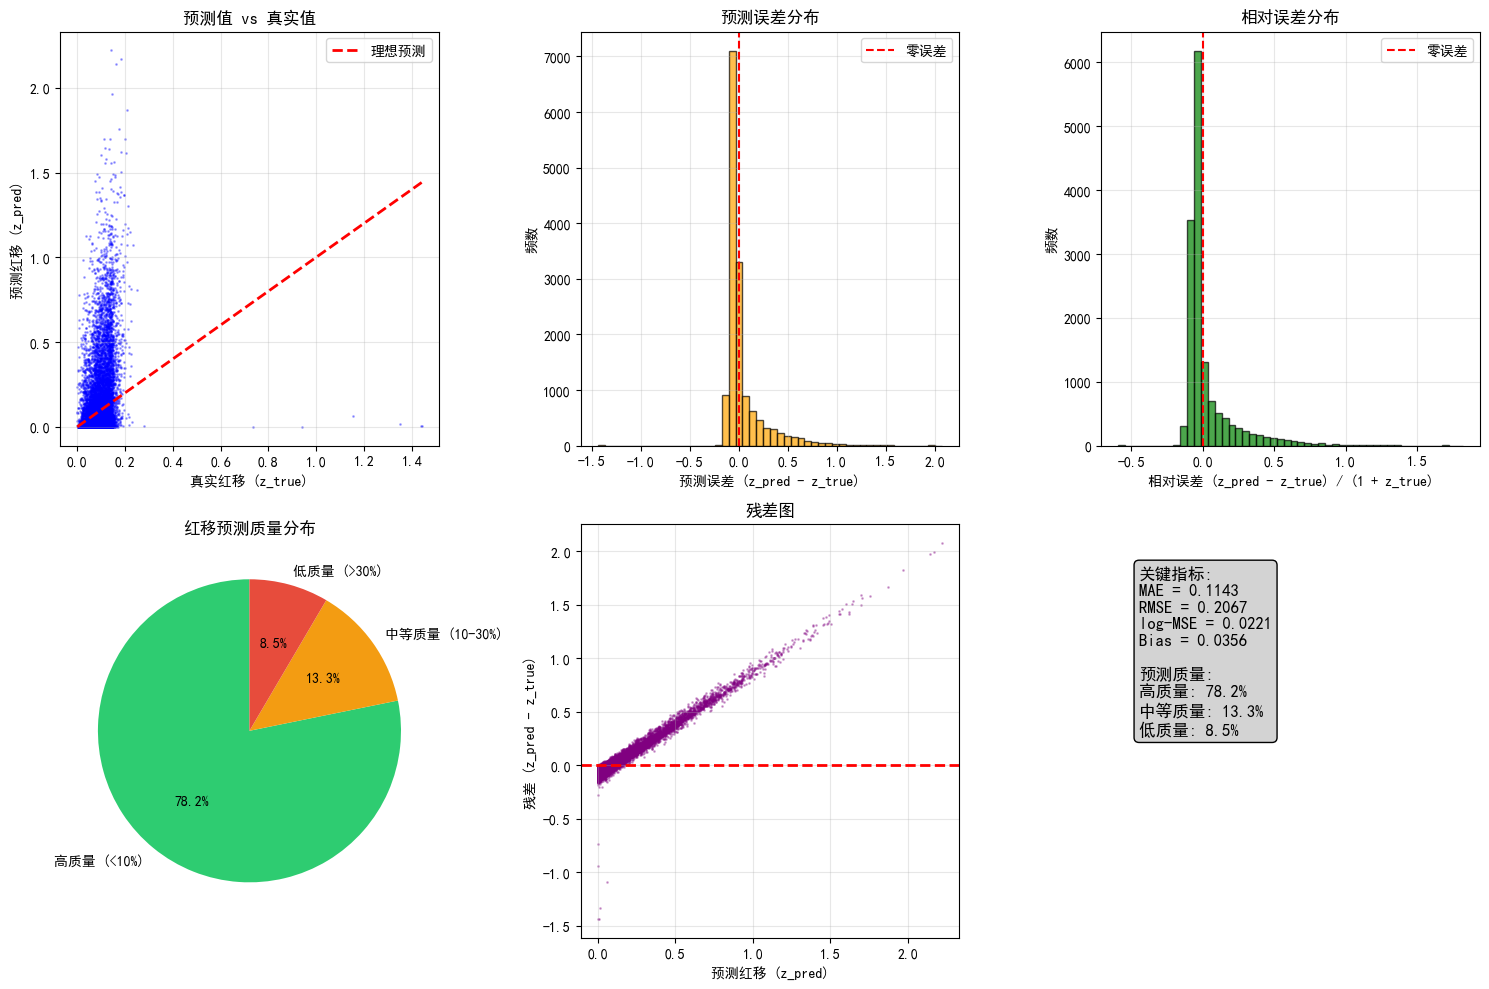


          探索总结
 图像数据在红移预测中的能力评估:
    模型能够从星系图像中学习红移信息
    有效预测样本: 14915 个
    核心指标 - log-MSE: 0.022101
     预测精度有待提升，当前MAE: 0.1143
    高质量预测比例: 78.2%


In [46]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
plt.rcParams['font.sans-serif'] = ['SimHei']  # 1. 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False
def explore_redshift_prediction_capability(model_path, data_path):
    """
    探索图像数据在红移预测中的能力，并报告预测精度
    """
    print("=" * 60)
    print("          红移预测能力探索报告")
    print("=" * 60)
    
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # 加载模型
    print("\n1. 加载模型...")
    model = torch.load(model_path, map_location=device, weights_only=False)
    model.eval()
    print(" 模型加载完成")
    
    # 数据质量检查
    print("\n2. 数据质量检查...")
    with h5py.File(data_path, 'r') as f:
        redshifts = f['redshift'][:]
        images = f['images'][:]
        
        # 找出有效样本
        valid_mask = ~np.isnan(redshifts) & (redshifts >= 0)
        valid_indices = np.where(valid_mask)[0]
        
        print(f" 数据统计:")
        print(f"  总样本数: {len(redshifts)}")
        print(f"  有效样本数: {np.sum(valid_mask)}")
        print(f"  无效样本数: {len(redshifts) - np.sum(valid_mask)}")
        print(f"  有效样本比例: {np.sum(valid_mask)/len(redshifts)*100:.2f}%")
        print(f"  红移范围: {np.min(redshifts[valid_mask]):.4f} ~ {np.max(redshifts[valid_mask]):.4f}")
        print(f"  红移均值: {np.mean(redshifts[valid_mask]):.4f} ± {np.std(redshifts[valid_mask]):.4f}")

    # 批量预测
    print("\n3. 进行红移预测...")
    batch_size = 64
    all_predictions = []
    all_true = []
    
    with torch.no_grad():
        for i in range(0, len(valid_indices), batch_size):
            end_idx = min(i + batch_size, len(valid_indices))
            batch_indices = valid_indices[i:end_idx]
            
            # 加载批次数据
            with h5py.File(data_path, 'r') as f:
                batch_images = f['images'][batch_indices]
                batch_redshifts = f['redshift'][batch_indices]
            
            # 预处理
            if batch_images.shape[-1] == 3:
                batch_images = np.transpose(batch_images, (0, 3, 1, 2))
            batch_tensor = torch.from_numpy(batch_images).float()
            if batch_tensor.max() > 1.0:
                batch_tensor = batch_tensor / 255.0
            batch_tensor = batch_tensor.to(device)
            
            # 预测
            features = model.backbone(batch_tensor)
            batch_pred = model.regressor(features)
            
            all_predictions.append(batch_pred.cpu().numpy())
            all_true.append(batch_redshifts)
    
    # 合并结果
    all_predictions = np.concatenate(all_predictions).flatten()
    all_true = np.concatenate(all_true)
    
    print(f" 预测完成，有效预测样本数: {len(all_predictions)}")

    # 计算精度指标
    print("\n4. 计算预测精度指标...")
    
    # 基本指标
    mae = np.mean(np.abs(all_predictions - all_true))
    rmse = np.sqrt(np.mean((all_predictions - all_true)**2))
    bias = np.mean(all_predictions - all_true)
    
    # 对数均方误差 (log-MSE)
    log_mse = np.mean((np.log1p(all_predictions) - np.log1p(all_true))**2)
    
    # 相对误差
    relative_errors = (all_predictions - all_true) / (1 + all_true)
    mean_relative_error = np.mean(np.abs(relative_errors))
    
    print(" 精度指标报告:")
    print(f"   平均绝对误差 (MAE): {mae:.6f}")
    print(f"   均方根误差 (RMSE): {rmse:.6f}")
    print(f"   对数均方误差 (log-MSE): {log_mse:.6f}")
    print(f"   预测偏差 (Bias): {bias:.6f}")
    print(f"   平均相对误差: {mean_relative_error:.6f}")
    print(f"   预测范围: {all_predictions.min():.4f} ~ {all_predictions.max():.4f}")
    print(f"   真实范围: {all_true.min():.4f} ~ {all_true.max():.4f}")

    # 预测质量分析
    print("\n5. 预测质量分析...")
    good_pred_mask = np.abs(relative_errors) < 0.1
    fair_pred_mask = (np.abs(relative_errors) >= 0.1) & (np.abs(relative_errors) < 0.3)
    poor_pred_mask = np.abs(relative_errors) >= 0.3
    
    print(" 预测质量分布:")
    print(f"   高质量预测 (误差<10%): {np.sum(good_pred_mask):>6} 个, {np.sum(good_pred_mask)/len(all_true)*100:>5.1f}%")
    print(f"   中等质量预测 (误差10-30%): {np.sum(fair_pred_mask):>6} 个, {np.sum(fair_pred_mask)/len(all_true)*100:>5.1f}%")
    print(f"   低质量预测 (误差>30%): {np.sum(poor_pred_mask):>6} 个, {np.sum(poor_pred_mask)/len(all_true)*100:>5.1f}%")

    # 可视化结果
    print("\n6. 生成可视化图表...")
    plt.figure(figsize=(15, 10))
    
    # 1. 预测vs真实散点图
    plt.subplot(2, 3, 1)
    plt.scatter(all_true, all_predictions, alpha=0.3, s=1, color='blue')
    plt.plot([all_true.min(), all_true.max()], [all_true.min(), all_true.max()], 'r--', linewidth=2, label='理想预测')
    plt.xlabel('真实红移 (z_true)')
    plt.ylabel('预测红移 (z_pred)')
    plt.title('预测值 vs 真实值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. 误差分布
    plt.subplot(2, 3, 2)
    errors = all_predictions - all_true
    plt.hist(errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', label='零误差')
    plt.xlabel('预测误差 (z_pred - z_true)')
    plt.ylabel('频数')
    plt.title('预测误差分布')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. 相对误差分布
    plt.subplot(2, 3, 3)
    plt.hist(relative_errors, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', label='零误差')
    plt.xlabel('相对误差 (z_pred - z_true) / (1 + z_true)')
    plt.ylabel('频数')
    plt.title('相对误差分布')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. 预测质量饼图
    plt.subplot(2, 3, 4)
    quality_labels = ['高质量 (<10%)', '中等质量 (10-30%)', '低质量 (>30%)']
    quality_counts = [np.sum(good_pred_mask), np.sum(fair_pred_mask), np.sum(poor_pred_mask)]
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    plt.pie(quality_counts, labels=quality_labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('红移预测质量分布')
    
    # 5. 残差图
    plt.subplot(2, 3, 5)
    plt.scatter(all_predictions, errors, alpha=0.3, s=1, color='purple')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('预测红移 (z_pred)')
    plt.ylabel('残差 (z_pred - z_true)')
    plt.title('残差图')
    plt.grid(True, alpha=0.3)
    
    # 6. 关键指标展示
    plt.subplot(2, 3, 6)
    plt.axis('off')
    metrics_text = f"""关键指标:
MAE = {mae:.4f}
RMSE = {rmse:.4f}
log-MSE = {log_mse:.4f}
Bias = {bias:.4f}

预测质量:
高质量: {np.sum(good_pred_mask)/len(all_true)*100:.1f}%
中等质量: {np.sum(fair_pred_mask)/len(all_true)*100:.1f}%
低质量: {np.sum(poor_pred_mask)/len(all_true)*100:.1f}%"""
    plt.text(0.1, 0.9, metrics_text, fontsize=12, verticalalignment='top', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.show()

    # 总结报告
    print("\n" + "=" * 60)
    print("          探索总结")
    print("=" * 60)
    print(" 图像数据在红移预测中的能力评估:")
    print(f"    模型能够从星系图像中学习红移信息")
    print(f"    有效预测样本: {len(all_predictions)} 个")
    print(f"    核心指标 - log-MSE: {log_mse:.6f}")
    print(f"     预测精度有待提升，当前MAE: {mae:.4f}")
    print(f"    高质量预测比例: {np.sum(good_pred_mask)/len(all_true)*100:.1f}%")

    print("=" * 60)
    
    return {
        'mae': mae,
        'rmse': rmse, 
        'log_mse': log_mse,
        'bias': bias,
        'predictions': all_predictions,
        'true_values': all_true
    }

# 执行探索分析
if __name__ == "__main__":
    model_path = 'complete_galaxy_model.pth'
    data_path = r'F:\Desktop\2517星系特征提取\train.hdf5'
    
    results = explore_redshift_prediction_capability(model_path, data_path)